In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import requests
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u
from astropy.time import Time

from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# Functions to return TLEs 

def get_TLE_dataframe(satellite_id, start_jd, end_jd):
    '''
    Use the Satchecker service to build a dataframe with historical TLEs for
    a satellite with a NORAD ID over a Julian Date Range.

    Useful NORAD satellite IDs include.

    41589: EUTELSAT 117B
    38991: Star One C3
    41886: GOES-16
    '''

    url = 'https://satchecker.cps.iau.org/tools/get-tle-data/'
    params = {'id': satellite_id,
            'id_type': 'catalog',
            'start_date_jd': start_jd,
            'end_date_jd': end_jd
            }
    r = requests.get(url, params=params)
    df = pd.DataFrame(r.json())

    df['epoch'] = pd.to_datetime(df['epoch'], utc=True)
    df.set_index('epoch', inplace=True)

    # Get rid of duplicate TLEs
    df = df[~df.index.duplicated(keep='first')]

    return df

def get_matching_tle(df, tai_time):
    '''
    Return the closest matching TLE in time
    '''
    
    # Convert to datetime format for pandas
    exp_time = pd.to_datetime([tai_time.utc.isot], utc=True)
    epoch_index = df.index.get_indexer(exp_time, method='nearest')

    best_tle_time = df.index[epoch_index]
    tle_delay = (best_tle_time - exp_time)/pd.Timedelta(hours=1)

    sat_name = df.satellite_name.iloc[epoch_index]
    TLE1 = df.tle_line1.iloc[epoch_index]
    TLE2 = df.tle_line2.iloc[epoch_index]

    return sat_name, best_tle_time, tle_delay, TLE1, TLE2

In [3]:
# Get TLEs for 2024
test_TLE = get_TLE_dataframe(41589, 2460311, 2460676 ) # 1/1 - 12/31 2024

In [4]:
# Set the location of the observatory 
rubin_obs = EarthLocation.of_site('Rubin Observatory')
Rubin= wgs84.latlon(rubin_obs.lat.deg, rubin_obs.lon.deg, rubin_obs.height.value)

# Make a skyfield timescale
timescale = load.timescale()

In [5]:
# Split the TLEs up by source
TLE_celestrak = test_TLE.query('data_source=="celestrak"').copy()
TLE_spacetrack = test_TLE.query('data_source=="spacetrack"').copy()
TLE_celestrak.sort_index(inplace=True)
TLE_spacetrack.sort_index(inplace=True)

# Initialize arrays and define a function to calculate satellite height.

heights_celestrak, times_celestrak = np.empty(365), np.empty(365, dtype='<U19')
heights_spacetrack, times_spacetrack = np.empty(365), np.empty(365, dtype='<U19')
time_diff = np.empty(365)

def calc_height(TLE, time):
   
    sat_name, best_tle_time, tle_delay, tle_line1, tle_line2 = get_matching_tle(TLE, time)
    satellite = EarthSatellite(tle_line1.iloc[0], tle_line2.iloc[0], sat_name.iloc[0], timescale)

    skyfield_time = timescale.from_astropy(time)
    sat_ra, sat_dec, sat_dist = (satellite - Rubin).at(skyfield_time).radec()
    height = wgs84.height_of(satellite.at(skyfield_time)).m

    return height, best_tle_time[0].replace(tzinfo=None).isoformat()

35786.182495859946 0.8580098466812567
35786.40123557273 1.1071965536540154
-0.2187397127837351 1.3657422926023473

35786.250379826815 0.660104447669667
35786.24129402677 0.682719310359085
9.085800041323123 236.82788609539838

Estimated systematic error on height calculation is 236.83 meters.


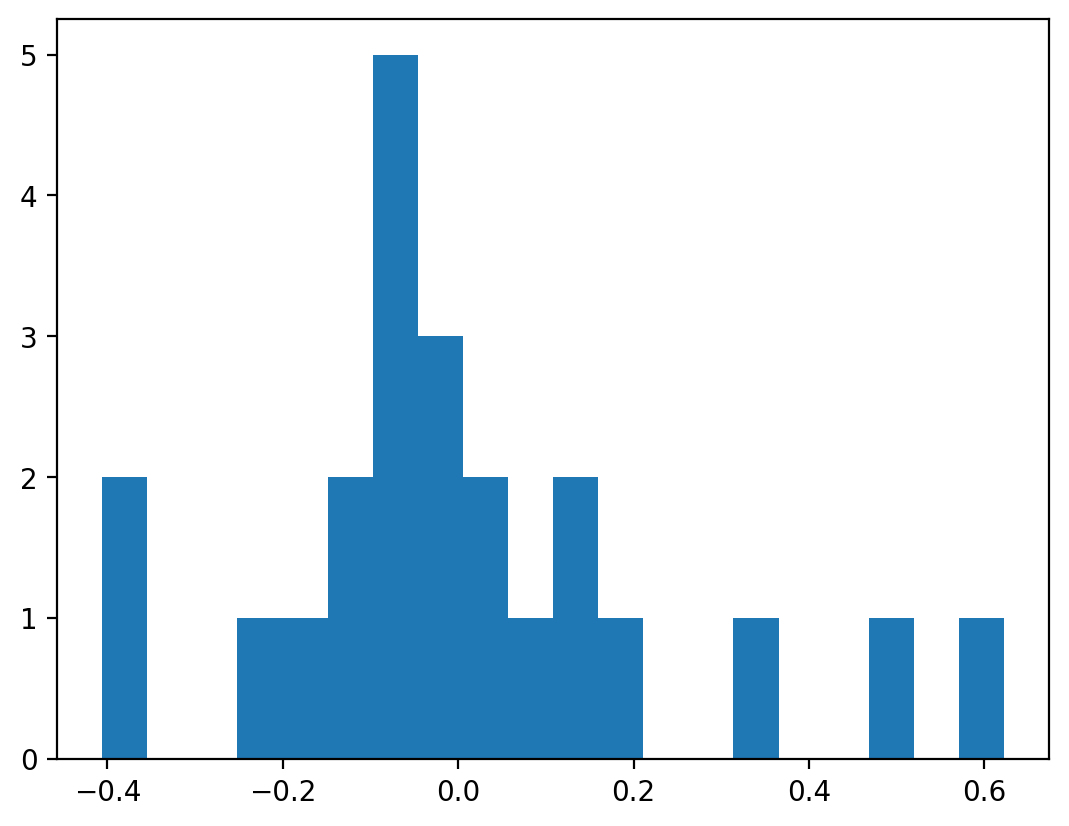

In [6]:
# For each day find the closest TLE from each source

jan_1 = Time("2024-01-01T0:00:00", scale='tai')

for i,day in enumerate(range(365)):
    
    time_test = jan_1 + day*u.day
        
    heights_celestrak[i], times_celestrak[i] = calc_height(TLE_celestrak, time_test)
    heights_spacetrack[i], times_spacetrack[i] = calc_height(TLE_spacetrack, time_test)
    time_diff[i] = (Time(times_celestrak[i], format='isot') - Time(times_spacetrack[i], format='isot')).jd

# Make a dataframe with retrieved and calculated information
height_df = pd.DataFrame({'heights_celestrak':heights_celestrak, 'heights_spacetrack':heights_spacetrack,
                          'times_celestrak':times_celestrak, 'times_spacetrack':times_spacetrack, 'time_diff':time_diff})
height_df['delta_height'] = height_df.heights_celestrak - height_df.heights_spacetrack

# Print statistics on height from the two TLE sets
print((height_df.heights_celestrak/1000).mean(), (height_df.heights_celestrak/1000).std())
print((height_df.heights_spacetrack/1000).mean(), (height_df.heights_spacetrack/1000).std())
print((height_df.delta_height/1000).mean(), (height_df.delta_height/1000).std())

# Require that the date of the TLE agree to within 1/2 day
limited = height_df.query('abs(time_diff)<.5')
plt.hist(limited.delta_height/1000, bins=20);

# Now print statistics on height from restricted sets.
print()
print((limited.heights_celestrak/1000).mean(), (limited.heights_celestrak/1000).std())
print((limited.heights_spacetrack/1000).mean(), (limited.heights_spacetrack/1000).std())
print((limited.delta_height).mean(), (limited.delta_height).std())
print(f'\nEstimated systematic error on height calculation is {(limited.delta_height).std():4.2f} meters.')

<Axes: xlabel='heights_spacetrack', ylabel='heights_celestrak'>

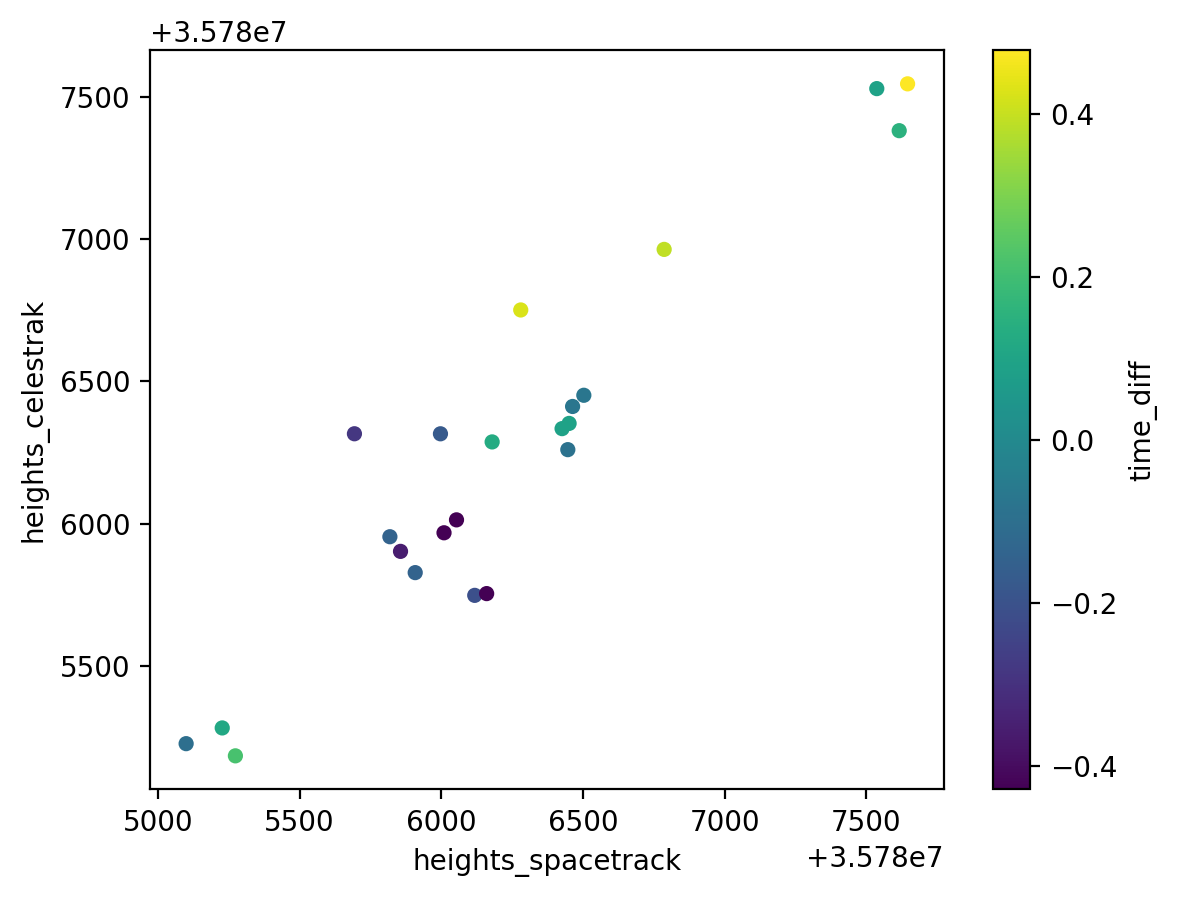

In [7]:
# Show height correlation betweeen the two TLE data sources for the ones close in time.
limited.plot('heights_spacetrack', 'heights_celestrak', kind='scatter', c='time_diff')